In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings

Install our package, then import it.

_this is here as an example, and for development, eventually this install step shouldn't be in the notebooks, only in the main readme_

In [2]:
%%bash
cd .. 
pip install . --upgrade

Processing /home/smb/Documents/code/DetectSimpsonParadox
  Found existing installation: detect-simpsons-paradox 0.1
    Uninstalling detect-simpsons-paradox-0.1:
      Successfully uninstalled detect-simpsons-paradox-0.1
  Running setup.py install for detect-simpsons-paradox: started
    Running setup.py install for detect-simpsons-paradox: finished with status 'done'


In [3]:
import detect_simpsons_paradox as dsp
#warnings.simplefilter(action='ignore', category=FutureWarning)

# Dataset Generation

In [4]:
N = 100
# sample data from 2 clusters
mu = np.asarray([[1,1],[5,5]])

z = np.random.randint(0,2,N)
x = np.asarray([np.random.multivariate_normal(mu[z_i],[[.6,-1],[0,.6]]) for z_i in z])

x3 = np.random.normal(0, 10, N)
latent_df = pd.DataFrame(data=x,
                       columns = ['x1', 'x2'])
# now we add somoe more columns
color_z = {0:'r', 1:'b'}
latent_df['x3'] = x3
latent_df['color'] = [color_z[z_i] for z_i in z]

char_zy = {0: {0:'x', 1:'o'}, 1:{0:'o', 1:'x'}}

y = np.random.choice([0,1],N,p=[.7,.3])
latent_df['y'] = y
latent_df['char'] = [char_zy[zi][yi] for zi,yi in zip(z,y)]

# Extract contiunous variables and categorical variables

Categorical attributes' types contain 'object' and 'int64'.
Continuous attributes' type contains float64.

In [5]:
# separate the continous attributes and categorical attributes from datasets
groupbyAttrs = latent_df.select_dtypes(include=['object','int64'])
continuousAttrs = latent_df.select_dtypes(include=['float64'])
continuousAttrs_labels = list(continuousAttrs)
groupbyAttrs_labels = list(groupbyAttrs)
print(continuousAttrs_labels)
print(groupbyAttrs_labels)

['x1', 'x2', 'x3']
['color', 'y', 'char']


Compute correaltion matrix for all of the data, then extract the upper triangle of the matrix.
Generate the correaltion dataframe by correlation values and their discrete variables' index.

In [6]:
all_corr = latent_df[continuousAttrs_labels].corr()

all_corr_df = dsp.upper_triangle_df(all_corr)
all_corr_element = all_corr_df['value'].values
print(all_corr_df)

      value  attr1  attr2
0  0.712814      0      1
1 -0.031917      0      2
2  0.118079      1      2


# Compare the signs of each correlation in the subgroup to the correlation for all
After comparing, the reverse result will be stored in the result_df dataframe for further usage. 

In [7]:
# Define an empty dataframe for result
result_df = pd.DataFrame()

for groupbyAttr in groupbyAttrs_labels:
    grouped_df_corr = latent_df.groupby(groupbyAttr)[continuousAttrs_labels].corr()
    groupby_value = grouped_df_corr.index.get_level_values(groupbyAttr).unique()
    
    # get subgroup correlation
    for subgroup in groupby_value:
        subgroup_corr = grouped_df_corr.loc[subgroup]
        
        # Extract subgroup 
        subgroup_corr_elements = dsp.upper_triangle_element(subgroup_corr)
        
        # Compare the signs of each element in subgroup to the correlation for all of the data
        # Get the index for reverse element
        index_list = [i for i, (a,b) in enumerate(zip(all_corr_element, subgroup_corr_elements)) 
                      if dsp.isReverse(a, b)]
        
        # Get reverse elements' correlation values
        reverse_list = [j for i, j in zip(all_corr_element, subgroup_corr_elements) 
                        if dsp.isReverse(i, j)]
        
        if reverse_list:
            # Retrieve attribute information from all_corr_df
            all_corr_info = [all_corr_df.loc[i].values for i in index_list]
            temp_df = pd.DataFrame(data=all_corr_info,columns=['allCorr','attr1','attr2'])
            
            # Convert index from float to int
            temp_df.attr1 = temp_df.attr1.astype(int)
            temp_df.attr2 = temp_df.attr2.astype(int)
            
            temp_df["reverseCorr"] = reverse_list
            len_list = len(reverse_list)
            # Store group attributes' information
            temp_df['groupbyAttr'] = [groupbyAttr for i in range(len_list)]
            temp_df['subgroup'] = [subgroup for i in range(len_list)]
            result_df = result_df.append(temp_df, ignore_index=True)
        
print(result_df)

    allCorr  attr1  attr2  reverseCorr groupbyAttr subgroup
0  0.712814      0      1    -0.672484       color        b
1  0.712814      0      1    -0.612158       color        r
2 -0.031917      0      2     0.014900        char        o


# TODO Visualization (Hard code modify)

In [8]:
# group by color
grouped_df_color = latent_df.groupby('color')['x1','x2','x3'].corr()
blue=grouped_df_color.loc['b']
red=grouped_df_color.loc['r']

# group by char
grouped_df_char = latent_df.groupby('char')['x1','x2','x3'].corr()
char_o=grouped_df_char.loc['o']
char_x=grouped_df_char.loc['x']

# create a 0 matrix for the irrelvant cells
s = (len(blue),len(blue))
zero = np.zeros(s)

# manipulate the subgroup matrix first after corr() method
color_group=np.vstack([np.hstack([blue, zero]), np.hstack([zero, red])])

# create a 0 matrix for the irrelvant cells
s = (len(all_corr),len(color_group))
zero1 = np.zeros(s)

# combine the correlation matrix of all of the data with subgroup by color
all_combined=np.vstack([np.hstack([all_corr, zero1]), np.hstack([zero1.transpose(), color_group])])

# Combine char group
s = (len(char_o),len(char_x))
zero = np.zeros(s)
char_group=np.vstack([np.hstack([char_o, zero]), np.hstack([zero, char_x])])
s = (len(all_combined),len(char_group))
zero1 = np.zeros(s)
all_combined=np.vstack([np.hstack([all_combined, zero1]), np.hstack([zero1.transpose(), char_group])])

__ why a heat map?__ 

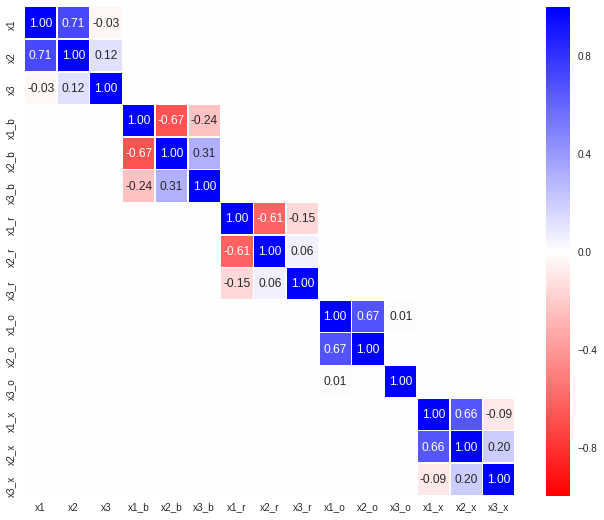

In [9]:
# Generate a heatmap for correlation matrix
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', ['red', 'white', 'blue'])
norm = plt.Normalize(-1,1)

labels =  ['x1','x2','x3','x1_b','x2_b','x3_b','x1_r','x2_r','x3_r','x1_o','x2_o','x3_o','x1_x','x2_x','x3_x']
plt.figure(figsize=(11, 9))

ax = sns.heatmap(all_combined, cmap=cmap, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, linewidths=.5, norm=norm, center=0)

# Offset 0.00
for t in ax.texts: 
    if t.get_text() == '0.00':
        t.set_text("")
plt.show()